In [96]:
import itertools
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb
from sklearn.metrics import classification_report
from xgboost.callback import EarlyStopping

In [97]:
train = pd.read_csv("Data/preprocessed/train_preprocessed.csv") 
test = pd.read_csv("Data/preprocessed/test_preprocessed.csv")        
target = pd.read_csv("Data/preprocessed/test_target.csv")  

In [98]:
X_train = train.drop(columns=["AdoptionSpeed", "PetID"])
y_train = train["AdoptionSpeed"]

X_test = test.drop(columns=["PetID"])
y_test = target["AdoptionSpeed"]

#### 1. Baseline: 41 % Accuracy, 0.40 F1 Score
#### 2. Parameter Raster bauen, alle Kombinationen per Grid Search durchlaufen
#### 3. Metriken, inkl. Accuracy, F1, Overfitting Indikatoren und Trainingszeit
#### 4. Analyse mit Heatmaps, etc.

learning rate --- max_depth

Tiefere Bäume benötigen niedrige Lernraten um Overfitting zu vermeiden und stabile Konvergenz zu gewährleisten. Hohe Lernraten mit tiefen Bäumen führen zu instabilem Training.

In [99]:
learning_rates = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
max_depths = [3, 5, 8, 10]

results = []

In [100]:
results = []
n_repeats = 2  # oder 10, je nach Rechenzeit

for lr, md in itertools.product(learning_rates, max_depths):
    acc_scores, f1_scores, logloss_train, logloss_test, gaps = [], [], [], [], []

    for r in range(n_repeats):
        model = xgb.XGBClassifier(
            objective="multi:softprob",
            num_class=5,
            use_label_encoder=False,
            random_state=42,  
            learning_rate=lr,
            max_depth=md,
            n_estimators=2000,
            eval_metric="mlogloss",        # hier korrekt
            early_stopping_rounds=50       # hier in deiner Version!
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False
        )

        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")

        # evals_result jetzt über Methode holen
        evals_result = model.evals_result()
        best_iter = model.best_iteration

        train_logloss = evals_result["validation_0"]["mlogloss"][best_iter]
        test_logloss  = evals_result["validation_1"]["mlogloss"][best_iter]
        gap = test_logloss - train_logloss

        # sammeln
        acc_scores.append(acc)
        f1_scores.append(f1)
        logloss_train.append(train_logloss)
        logloss_test.append(test_logloss)
        gaps.append(gap)

    # Mittelwerte über Wiederholungen
    results.append({
        "lr": lr,
        "max_depth": md,
        "acc_mean": np.mean(acc_scores),
        "f1_mean": np.mean(f1_scores),
        "train_logloss": np.mean(logloss_train),
        "test_logloss": np.mean(logloss_test),
        "overfit_gap": np.mean(gaps)
    })


/Users/basti/miniforge3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:16:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/basti/miniforge3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:16:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/basti/miniforge3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:16:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/Users/basti/miniforge3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [14:16:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_e

In [101]:
df_results = pd.DataFrame(results)
print(df_results)

      lr  max_depth  acc_mean   f1_mean  train_logloss  test_logloss  \
0   0.01          3  0.373989  0.352031       1.350192      1.431449   
1   0.01          5  0.390861  0.367780       1.132855      1.394011   
2   0.01          8  0.406327  0.384328       0.914279      1.375169   
3   0.01         10  0.435501  0.416156       0.647846      1.362184   
4   0.02          3  0.383831  0.364568       1.273414      1.413699   
5   0.02          5  0.397891  0.375660       1.068661      1.387409   
6   0.02          8  0.416520  0.395561       0.823157      1.369314   
7   0.02         10  0.439367  0.418716       0.594375      1.357900   
8   0.05          3  0.396134  0.377466       1.206154      1.403730   
9   0.05          5  0.400703  0.378805       1.005063      1.385942   
10  0.05          8  0.417223  0.396052       0.759456      1.369939   
11  0.05         10  0.438664  0.419353       0.614857      1.357923   
12  0.10          3  0.396134  0.375817       1.167582      1.39

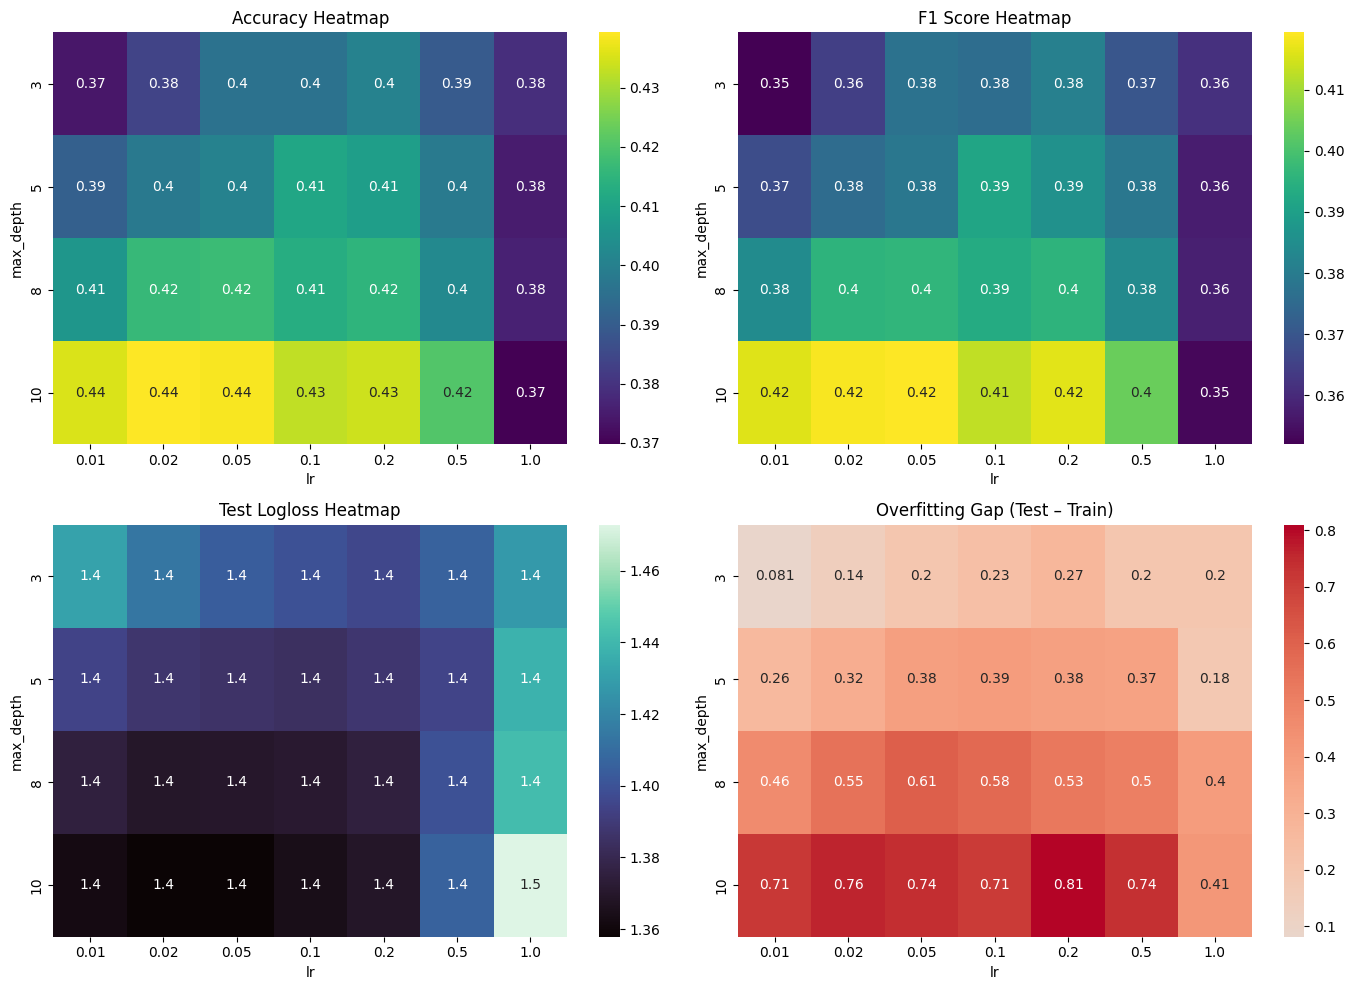

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmaps für alle relevanten Metriken
pivot_acc   = df_results.pivot(index="max_depth", columns="lr", values="acc_mean")
pivot_f1    = df_results.pivot(index="max_depth", columns="lr", values="f1_mean")
pivot_log   = df_results.pivot(index="max_depth", columns="lr", values="test_logloss")
pivot_gap   = df_results.pivot(index="max_depth", columns="lr", values="overfit_gap")

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

sns.heatmap(pivot_acc, annot=True, cmap="viridis", ax=ax[0,0])
ax[0,0].set_title("Accuracy Heatmap")

sns.heatmap(pivot_f1, annot=True, cmap="viridis", ax=ax[0,1])
ax[0,1].set_title("F1 Score Heatmap")

sns.heatmap(pivot_log, annot=True, cmap="mako", ax=ax[1,0])
ax[1,0].set_title("Test Logloss Heatmap")

sns.heatmap(pivot_gap, annot=True, cmap="coolwarm", center=0, ax=ax[1,1])
ax[1,1].set_title("Overfitting Gap (Test – Train)")

plt.tight_layout()
plt.show()


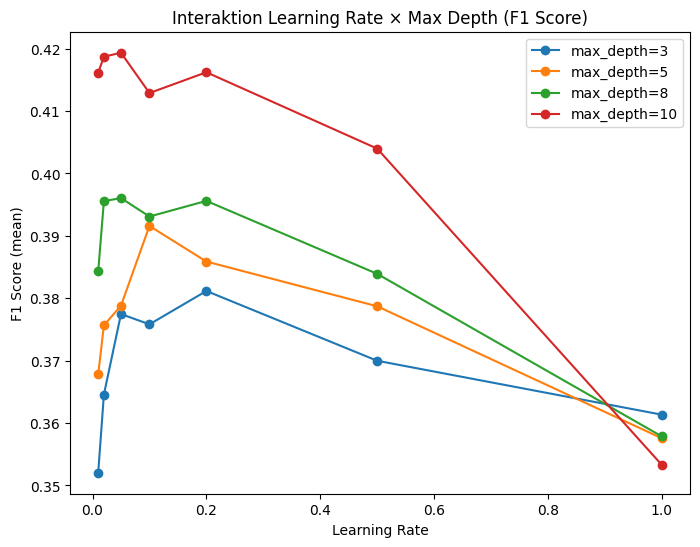

In [105]:
# Linienplot für F1 Score über Learning Rates je Baumtiefe
plt.figure(figsize=(8,6))
for md in sorted(df_results["max_depth"].unique()):
    subset = df_results[df_results["max_depth"] == md]
    plt.plot(subset["lr"], subset["f1_mean"], marker="o", label=f"max_depth={md}")

plt.xlabel("Learning Rate")
plt.ylabel("F1 Score (mean)")
plt.title("Interaktion Learning Rate × Max Depth (F1 Score)")
plt.legend()
plt.show()

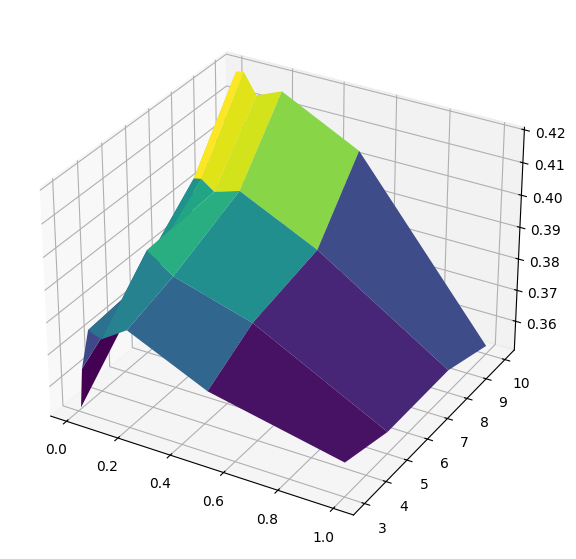

In [104]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")
X, Y = np.meshgrid(pivot_f1.columns, pivot_f1.index)
Z = pivot_f1.values
ax.plot_surface(X, Y, Z, cmap=cm.viridis)


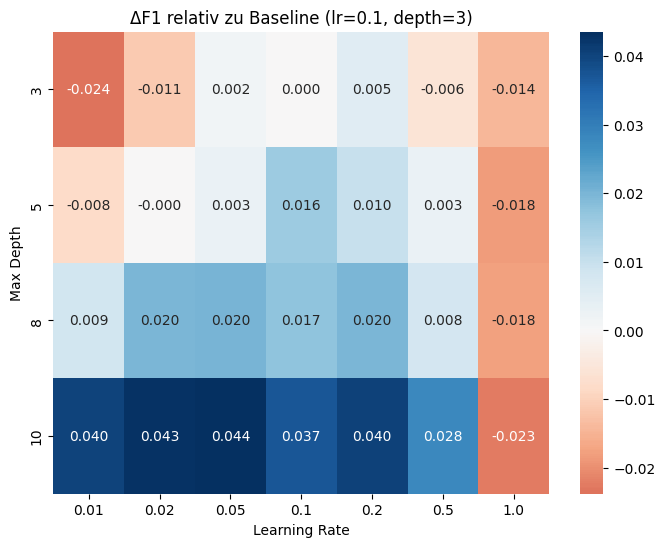

In [108]:
# Referenzpunkt wählen (z. B. flacher Baum + moderate LR)
baseline_lr = 0.1
baseline_md = 3

baseline_value = df_results[
    (df_results["lr"] == baseline_lr) & (df_results["max_depth"] == baseline_md)
]["f1_mean"].values[0]

# Differenz berechnen
df_results["f1_delta"] = df_results["f1_mean"] - baseline_value

# Pivot für Heatmap
pivot_delta = df_results.pivot(index="max_depth", columns="lr", values="f1_delta")

plt.figure(figsize=(8,6))
sns.heatmap(pivot_delta, annot=True, cmap="RdBu", center=0, fmt=".3f")
plt.title(f"ΔF1 relativ zu Baseline (lr={baseline_lr}, depth={baseline_md})")
plt.xlabel("Learning Rate")
plt.ylabel("Max Depth")
plt.show()
